dQ/dt=(kA(T2-T1))/d
T=Q/mc
Q=heat transfered
k=thermal conductivity
A=surface area
T1=first temp
T2=second temp
d=thickness
m=mass
Cmarshmallow=specific heat
Cair

In [40]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

Here we are defining the values of our initial state

In [41]:
eTemp=360
#oTemp=mTemp=iTemp=290
#outer=middle=inner=(2.33*2.02)/oTemp
#(2.33*2.02)/oTemp
209/(2.33*2.02)

44.405728126460716

Haven't yet figured out how to include this into the code,
we will eventually make it a sweep, 
I just hard-coded these values for now

The energy and tempurature of each sub-section are each a stock, 
   because they all effect eachother and need to be calculated over time.
   The mass of each ring in the marshmallow is the same, and the thickness and area are based on that.
   We used the conductivity of bread as a proxy for that of a marshmallow. 
   We were able to find data of the specific heat of a marshmallow.

In [67]:
def make_system(eTemp):
   
    init = State(outer=44.4, middle=44.4, inner=44.4, 
                 oTemp=290, mTemp=290, iTemp=290)
    dt=1
    conductivity=0.1
    areaOuter=0.004054
    areaMiddle=0.003091
    areaInner=0.001946
    thicknessOuter=0.00161
    thicknessMiddle=0.00229
    thicknessInner=0.0088
    mass=2.33
    specificMarshmallow=2.02
    t0=0
    t_end=1000

    
    return System(init=init, dt=dt, conductivity=conductivity, 
                  areaOuter=areaOuter, areaMiddle=areaMiddle, 
                  areaInner=areaInner, thicknessOuter=thicknessOuter, 
                  thicknessMiddle=thicknessMiddle, 
                  thicknessInner=thicknessInner, mass=mass, 
                  specificMarshmallow=specificMarshmallow, t0=t0, t_end=t_end)

In [68]:
def update_func(state, t, system):
    """Updates the energy in the sections, then based on this calculates and stores the temperature of each section
    """
    outer, middle, inner, oTemp, mTemp, iTemp = state
    unpack(system)
    dQdt1 = (conductivity*areaOuter*(eTemp-oTemp))/thicknessOuter #W/mK*m^2*K/m = W
    dQdt2 = (conductivity*areaMiddle*(oTemp-mTemp))/thicknessMiddle
    dQdt3 = (conductivity*areaInner*(mTemp-iTemp))/thicknessInner
    dTdtinner = inner/(mass*specificMarshmallow)
    dTdtmiddle = middle/(mass*specificMarshmallow)
    dTdtouter = outer/(mass*specificMarshmallow)
    
    outer += (dQdt1 - dQdt2)*dt
    middle += (dQdt2 - dQdt3)*dt
    inner += (dQdt3)*dt
    
    oTemp += dTdtouter*dt
    mTemp += dTdtmiddle*dt
    iTemp += dTdtinner*dt
 
    return State(outer=outer, middle=middle, inner=inner, oTemp=oTemp, mTemp=mTemp, iTemp=iTemp)

In [69]:
#state = update_func(init, 1, system)

In [70]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [65]:
def plot_results(oTemp, mTemp, iTemp):
    
    plot(oTemp, '--', label='Outer Temp')
    plot(mTemp, '-', label='Middle Temp')
    plot(iTemp, '-', label='Inner Temp')
    decorate(xlabel='Time (seconds)',
             ylabel='Tempurature(K)')

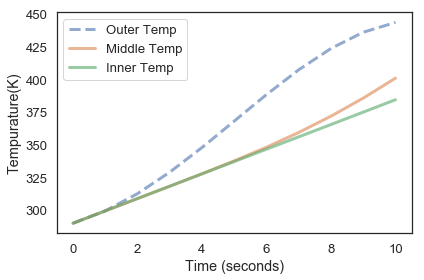

In [66]:
system = make_system(eTemp)
results = run_simulation(system, update_func)

plot_results(results.oTemp, results.mTemp, results.iTemp)